# Test stuff for PFN model

Classify pions, photons, and **scalars**

In [1]:
# Add import paths
import sys
sys.path.append("..")

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import datetime as dt
from utils import print_gpu_memory

# Make tensorflow not use too much memory
import tensorflow as tf
gpus = tf.config.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

disk_dir = "/usatlas/atlas01/atlasdisk/users/atlas_wifeng"

In [2]:
# Get data
from data import get_data
(X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = get_data("scalar_test/30k_jets_point_cloud.npz")

In [31]:
# Build model
from model import PFN
Phi_sizes = [128, 128, 128, 128, 64, 64, 64]
F_sizes = [128, 128, 128, 128, 64, 64, 64]

_, n_particles, n_features = X_train.shape
model = PFN(
    n_features=n_features,
    n_particles=n_particles,
    n_outputs=Y_train.shape[1],
    Phi_sizes=Phi_sizes,
    F_sizes=F_sizes
)

In [32]:
from collections import defaultdict
history = defaultdict(list)

In [33]:
# Utility functions for training
from train_model import train_model

def train_iteration(lr, epochs):
    fit_history = train_model(
        model=model, 
        data=(X_train, X_val, Y_train, Y_val),
        lr=lr,
        epochs=epochs
    )
    print(f"\nSaving history...")
    for key in ["loss", "val_loss", "accuracy", "val_accuracy"]:
        history[key].extend(fit_history.history[key])
    return fit_history

def save_model():
    model_dir = f"{disk_dir}/photon-jet/models/pfn"
    cur_date = dt.datetime.now().strftime("%Y-%m-%d")
    os.makedirs(f"{model_dir}/{cur_date}", exist_ok=True)
    model.save(f"{model_dir}/{cur_date}/{dt.datetime.now()}")

In [34]:
print_gpu_memory()

GPU memory usage
  current: 825.13 MB
  peak:    1.14 GB


In [35]:
print(f"=== Training [{dt.datetime.now()}] ===")
train_iteration(lr=1e-3, epochs=9)

Training model...
=== Training [2023-06-07 17:33:41.920284] ===
Epoch 1/9
240/240 [==============================] - 9s 20ms/step - loss: 8.4253 - accuracy: 0.3305 - val_loss: 1.1226 - val_accuracy: 0.3287
Epoch 2/9
240/240 [==============================] - 5s 19ms/step - loss: 1.1472 - accuracy: 0.3372 - val_loss: 1.1459 - val_accuracy: 0.3353
Epoch 3/9
240/240 [==============================] - 5s 19ms/step - loss: 1.1293 - accuracy: 0.3328 - val_loss: 1.1050 - val_accuracy: 0.3287
Epoch 4/9
240/240 [==============================] - 5s 19ms/step - loss: 1.1193 - accuracy: 0.3354 - val_loss: 1.1067 - val_accuracy: 0.3370
Epoch 5/9
240/240 [==============================] - 5s 19ms/step - loss: 1.1247 - accuracy: 0.3384 - val_loss: 1.1393 - val_accuracy: 0.3287
Epoch 6/9
240/240 [==============================] - 5s 19ms/step - loss: 1.1100 - accuracy: 0.3444 - val_loss: 1.1008 - val_accuracy: 0.3343
Epoch 7/9
240/240 [==============================] - 5s 19ms/step - loss: 1.1033 - a

In [38]:
print(f"=== Training [{dt.datetime.now()}] ===")
train_iteration(lr=2e-4, epochs=9)

=== Training [2023-06-07 17:37:03.912953] ===
Epoch 1/9
240/240 [==============================] - 9s 20ms/step - loss: 1.0110 - accuracy: 0.4584 - val_loss: 0.9860 - val_accuracy: 0.4743
Epoch 2/9
240/240 [==============================] - 5s 19ms/step - loss: 0.9918 - accuracy: 0.4695 - val_loss: 0.9790 - val_accuracy: 0.4730
Epoch 3/9
240/240 [==============================] - 5s 19ms/step - loss: 0.9936 - accuracy: 0.4760 - val_loss: 0.9770 - val_accuracy: 0.4753
Epoch 4/9
240/240 [==============================] - 5s 19ms/step - loss: 0.9852 - accuracy: 0.4791 - val_loss: 0.9772 - val_accuracy: 0.4927
Epoch 5/9
240/240 [==============================] - 5s 19ms/step - loss: 0.9821 - accuracy: 0.4802 - val_loss: 0.9999 - val_accuracy: 0.4673
Epoch 6/9
240/240 [==============================] - 5s 19ms/step - loss: 0.9804 - accuracy: 0.4848 - val_loss: 0.9698 - val_accuracy: 0.4863
Epoch 7/9
240/240 [==============================] - 5s 19ms/step - loss: 0.9766 - accuracy: 0.4882 - 

### Evaluate model

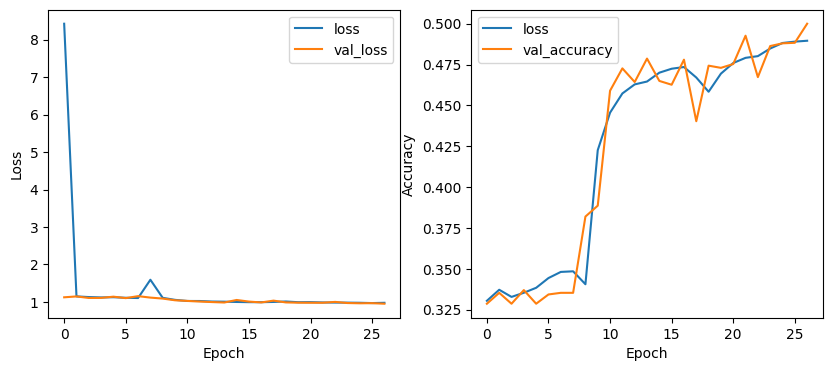

In [40]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
ax1, ax2 = axs

ax1.plot(history["loss"])
ax1.plot(history["val_loss"])
ax1.legend(["loss", "val_loss"])
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss");

ax2.plot(history["accuracy"])
ax2.plot(history["val_accuracy"])
ax2.legend(["loss", "val_accuracy"])
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy");

6/6 [==============================] - 0s 30ms/step
Testing accuracy: 0.398


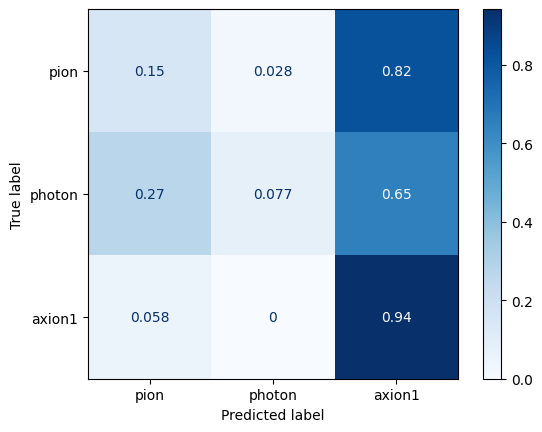

In [11]:
# Test model
from test_model import test_model, plot_cm
test_accuracy, cm = test_model(model, (X_test, Y_test))
print(f"Testing accuracy: {test_accuracy}")

plot_cm(cm, ["pion", "photon", "axion1"])